In [1]:
import numpy as np
import matplotlib.pyplot as plt

import codecs
import re
import os.path

# Données reconnaissance du locuteur (Chirac/Mitterrand)

In [2]:
# Chargement des données:
def load_pres(fname):
    alltxts = []
    alllabs = []
    s=codecs.open(fname, 'r','utf-8') # pour régler le codage
    while True:
        txt = s.readline()
        if(len(txt))<5:
            break
        #
        lab = re.sub(r"<[0-9]*:[0-9]*:(.)>.*","\\1",txt)
        txt = re.sub(r"<[0-9]*:[0-9]*:.>(.*)","\\1",txt)
        if lab.count('M') >0:
            alllabs.append(-1)
        else: 
            alllabs.append(1)
        alltxts.append(txt)
    return alltxts,alllabs


In [3]:
fname = "./datasets/AFDpresidentutf8/corpus.tache1.learn.utf8"
alltxts,alllabs = load_pres(fname)

In [16]:
print(f'{len(alltxts)} phrases')
print('Chirac == label 1 et Mitterand == label -1')
print(f'{alltxts[0]} -> classe: {alllabs[0]}')
print(f'{alltxts[11]} -> classe: {alllabs[11]}')
print(f'Chirac: {np.sum(np.array(alllabs) == 1)} phrases - Mitterand: {np.sum(np.array(alllabs) == -1)} phrases')
print(f'on remarque que Chirac a parlé {np.round(49890/7523)} fois plus que Mitterand')

57413 phrases
Chirac == label 1 et Mitterand == label -1
 Quand je dis chers amis, il ne s'agit pas là d'une formule diplomatique, mais de l'expression de ce que je ressens.
 -> classe: 1
 Je ne sais ni pourquoi ni comment on s'est opposé il y a quelques douze années - douze ou treize ans - à la création de l'Université technologique.
 -> classe: -1
Chirac: 49890 phrases - Mitterand: 7523 phrases
on remarque que Chirac a parlé 7.0 fois plus que Mitterand


# Données classification de sentiments (films)

In [13]:
def load_movies(path2data): # 1 classe par répertoire
    alltxts = [] # init vide
    labs = []
    cpt = 0
    for cl in os.listdir(path2data): # parcours des fichiers d'un répertoire
        for f in os.listdir(path2data+cl):
            txt = open(path2data+cl+'/'+f).read()
            alltxts.append(txt)
            labs.append(cpt)
        cpt+=1 # chg répertoire = cht classe
        
    return alltxts,labs


In [14]:
path = "./datasets/movies/movies1000/"

alltxts_mov,alllabs_mov = load_movies(path)

In [15]:
print(len(alltxts_mov),len(alllabs_mov))
print(alltxts_mov[0])
print(alllabs_mov[0])
print(alltxts_mov[-1])
print(alllabs_mov[-1])

2000 2000
plot : two teen couples go to a church party , drink and then drive . 
they get into an accident . 
one of the guys dies , but his girlfriend continues to see him in her life , and has nightmares . 
what's the deal ? 
watch the movie and " sorta " find out . . . 
critique : a mind-fuck movie for the teen generation that touches on a very cool idea , but presents it in a very bad package . 
which is what makes this review an even harder one to write , since i generally applaud films which attempt to break the mold , mess with your head and such ( lost highway & memento ) , but there are good and bad ways of making all types of films , and these folks just didn't snag this one correctly . 
they seem to have taken this pretty neat concept , but executed it terribly . 
so what are the problems with the movie ? 
well , its main problem is that it's simply too jumbled . 
it starts off " normal " but then downshifts into this " fantasy " world in which you , as an audience member , 

# A) Transformation paramétrique du texte (pre-traitements)

Vous devez tester, par exemple, les cas suivants:
- transformation en minuscule ou pas
- suppression de la ponctuation
- transformation des mots entièrement en majuscule en marqueurs spécifiques
- suppression des chiffres ou pas
- conservation d'une partie du texte seulement (seulement la première ligne = titre, seulement la dernière ligne = résumé, ...)
- stemming
- ...


Vérifier systématiquement sur un exemple ou deux le bon fonctionnement des méthodes sur deux documents (au moins un de chaque classe).

In [17]:
import string 
import unicodedata
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import FrenchStemmer
nltk.download('punkt')

punc = string.punctuation 
punc += '\n\r\t'
stemmer = FrenchStemmer()

for i in range(0,len(alltxts)):
    #alltxts[i] = re.sub('[0-9]+', '', alltxts[i]) #a garder ou enlever
    alltxts[i] = alltxts[i].lower() 
    alltxts[i] = alltxts[i].translate(str.maketrans(punc, ' ' * len(punc))) #ponctuation
    alltxts[i] = unicodedata.normalize('NFD', alltxts[i]).encode('ascii', 'ignore').decode("utf-8") #normalize en unicode, enleve non ascii et reconvertir en utf 8
    words = word_tokenize(alltxts[i], language='french')
    stemmed = [stemmer.stem(word) for word in words]
    alltxts[i] = ' '.join(stemmed)

print('Processed:')
print(f'\nclass: {alllabs[0]} , texte: {alltxts[0]}')
print(f'\nclass: {alllabs[11]} , texte: {alltxts[11]}')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\titouan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Processed:

class: 1 , texte: quand je dis cher amis il ne s agit pas la d une formul diplomat mais de l express de ce que je ressen

class: -1 , texte: je ne sais ni pourquoi ni comment on s est oppos il y a quelqu douz anne douz ou treiz an a la creation de l universit technolog


# B) Extraction du vocabulaire (BoW)

- **Exploration préliminaire des jeux de données**
    - Quelle est la taille d'origine du vocabulaire?
    - Que reste-t-il si on ne garde que les 100 mots les plus fréquents? [word cloud]
    - Quels sont les 100 mots dont la fréquence documentaire est la plus grande? [word cloud]
    - Quels sont les 100 mots les plus discriminants au sens de odds ratio? [word cloud]
    - Quelle est la distribution d'apparition des mots (Zipf)
    - Quels sont les 100 bigrammes/trigrammes les plus fréquents?

- **Variantes de BoW**
    - TF-IDF
    - Réduire la taille du vocabulaire (min_df, max_df, max_features)
    - BoW binaire
    - Bi-grams, tri-grams
    - **Quelles performances attendre ? Quels sont les avantages et les inconvénients des ces variantes?**

In [25]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
from sklearn.feature_selection import mutual_info_classif
import pandas as pd

''' Exploration préliminaire des jeux de données '''
nltk.download('stopwords')

all_words = ' '.join(alltxts).split()

# frequence de chaque mot avec counter
word_freq = Counter(all_words)

# Quelle est la taille d'origine du vocabulaire?
original_vocab_size = len(word_freq)
print(f"Taille d'origine du vocabulaire: {original_vocab_size}")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\titouan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Taille d'origine du vocabulaire: 14374


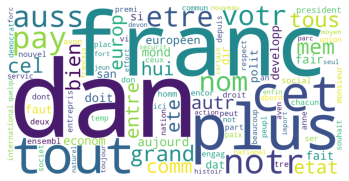

20 most frequent words
dan      11821
franc     7666
plus      7443
tout      6461
cet       5934
notr      5821
pay       4494
auss      4366
etre      3854
votr      3733
nom       3578
grand     3565
tous      3457
mem       3428
cel       3135
bien      3026
comm      2838
entre     2807
etat      2696
ete       2628
dtype: int64
14263
698753


In [27]:
# - Que reste-t-il si on ne garde que les 100 mots les plus fréquents? [word cloud]
#removed stopwords
vectorizer = CountVectorizer(stop_words=stopwords.words("french"))
X = vectorizer.fit_transform(alltxts)
frequent_words = pd.Series(
    np.array(X.sum(axis=0))[0], index=sorted(vectorizer.vocabulary_)
)

wordcloud = WordCloud(background_color="white", max_words=100, width=2000, height=1000)
wordcloud.generate_from_frequencies(frequent_words)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

print("20 most frequent words")
print(frequent_words.sort_values(ascending=False)[:20])
print(len(frequent_words))
print(sum(frequent_words))

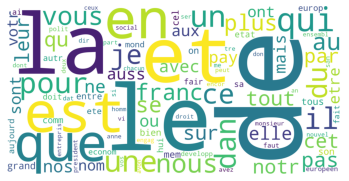

20 most frequent words
de       91351
le       52291
la       43944
et       37281
est      17401
en       16553
que      16292
qui      15635
un       12974
une      12698
il       12367
pour     11964
dan      11821
ce       10784
du       10775
je       10286
nous      9590
vous      9499
au        8122
franc     7666
dtype: int64
14341
1205099


In [30]:
#kept stopwords
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(alltxts)
frequent_words = pd.Series(
    np.array(X.sum(axis=0))[0], index=sorted(vectorizer.vocabulary_)
)

wordcloud = WordCloud(background_color="white", max_words=100, width=2000, height=1000)
wordcloud.generate_from_frequencies(frequent_words)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

print("20 most frequent words")
print(frequent_words.sort_values(ascending=False)[:20])
print(len(frequent_words))
print(sum(frequent_words))

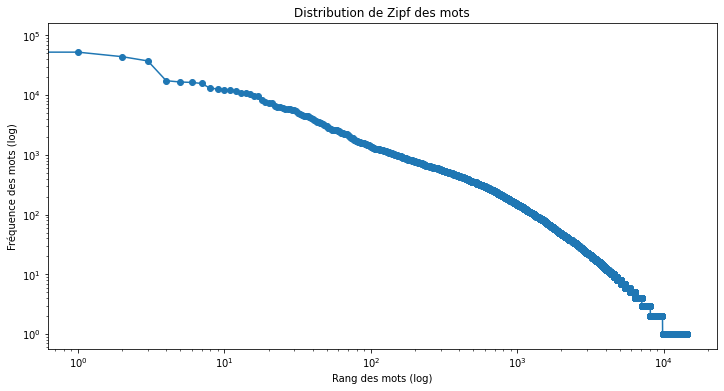

In [31]:
#Quelle est la distribution d'apparition des mots (Zipf)
word_counts = np.array(X.sum(axis=0))[0]
sorted_indices = np.argsort(word_counts)[::-1] 

sorted_word_counts = word_counts[sorted_indices]
plt.figure(figsize=(12, 6))
plt.plot(sorted_word_counts, marker='o')
plt.xscale('log')
plt.yscale('log')
plt.title('Distribution de Zipf des mots')
plt.xlabel('Rang des mots (log)')
plt.ylabel('Fréquence des mots (log)')
plt.show()


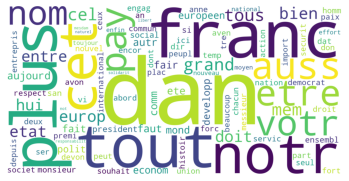

20 most frequent words
dan      1375.442059
franc    1137.578846
plus     1064.181286
tout      944.090273
notr      943.015251
cet       891.964654
auss      740.130186
pay       717.101478
etre      670.849568
votr      654.982767
nom       626.352071
grand     609.349844
tous      608.181239
cel       591.546577
mem       589.922962
bien      544.987273
doit      522.966861
europ     521.058469
etat      504.535386
entre     494.938165
dtype: float64
14263
180084.081505652


In [34]:
#- Quels sont les 100 mots dont la fréquence documentaire est la plus grande? [word cloud]
#removed stopwords
vectorizer = TfidfVectorizer(stop_words=stopwords.words("french"))
X = vectorizer.fit_transform(alltxts)
frequent_words = pd.Series(
    np.array(X.sum(axis=0))[0], index=sorted(vectorizer.vocabulary_)
)

wordcloud = WordCloud(background_color="white", max_words=100, width=2000, height=1000)
wordcloud.generate_from_frequencies(frequent_words)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

print("20 most frequent words")
print(frequent_words.sort_values(ascending=False)[:20])
print(len(frequent_words))
print(sum(frequent_words))

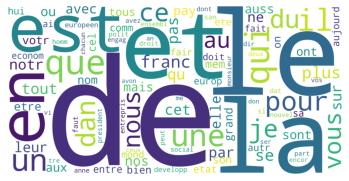

20 most frequent words
de       91351
le       52291
la       43944
et       37281
est      17401
en       16553
que      16292
qui      15635
un       12974
une      12698
il       12367
pour     11964
dan      11821
ce       10784
du       10775
je       10286
nous      9590
vous      9499
au        8122
franc     7666
dtype: int64
14341
1205099


In [33]:
#kept stopwords
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(alltxts)
frequent_words = pd.Series(
    np.array(X.sum(axis=0))[0], index=sorted(vectorizer.vocabulary_)
)

wordcloud = WordCloud(background_color="white", max_words=100, width=2000, height=1000)
wordcloud.generate_from_frequencies(frequent_words)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

print("20 most frequent words")
print(frequent_words.sort_values(ascending=False)[:20])
print(len(frequent_words))
print(sum(frequent_words))

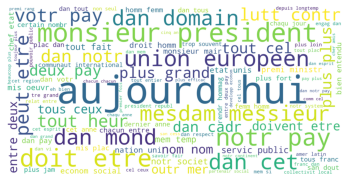

20 most frequent bigrams and trigrams
aujourd hui           2581
monsieur president     923
doit etre              816
notr pay               792
union europeen         664
dan cet                631
dan mond               626
mesdam messieur        611
dan domain             610
peut etre              479
votr pay               461
dan notr               404
tout heur              394
lutt contr             383
plus grand             371
deux pay               370
plus plus              367
tout cel               354
dan cadr               344
doivent etre           305
dtype: int64
863263
1225856


In [37]:
#Quels sont les 100 bigrammes/trigrammes les plus fréquents?
#removed stopwords
vectorizer = CountVectorizer(stop_words=stopwords.words("french"), ngram_range=(2,3)) 
X = vectorizer.fit_transform(alltxts)
frequent_words = pd.Series(
    np.array(X.sum(axis=0))[0], index=sorted(vectorizer.vocabulary_)
)

wordcloud = WordCloud(background_color="white", max_words=100, width=2000, height=1000)
wordcloud.generate_from_frequencies(frequent_words)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

print("20 most frequent bigrams and trigrams")
print(frequent_words.sort_values(ascending=False)[:20])
print(len(frequent_words))
print(sum(frequent_words))


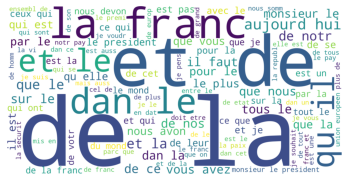

20 most frequent bigrams and trigrams
de la          12024
et de           5667
la franc        4092
dan le          3658
et le           2815
qu il           2772
aujourd hui     2581
et la           2244
que le          2115
de notr         1951
sur le          1795
de nos          1753
de ce           1729
il faut         1722
tous le         1667
dan la          1625
que nous        1610
vous avez       1588
monsieur le     1508
pour le         1467
dtype: int64
925370
2238189


In [38]:
#kept stopwords
vectorizer = CountVectorizer(ngram_range=(2,3)) 
X = vectorizer.fit_transform(alltxts)
frequent_words = pd.Series(
    np.array(X.sum(axis=0))[0], index=sorted(vectorizer.vocabulary_)
)

wordcloud = WordCloud(background_color="white", max_words=100, width=2000, height=1000)
wordcloud.generate_from_frequencies(frequent_words)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

print("20 most frequent bigrams and trigrams")
print(frequent_words.sort_values(ascending=False)[:20])
print(len(frequent_words))
print(sum(frequent_words))

In [40]:
#- Quels sont les 100 mots les plus discriminants au sens de odds ratio? [word cloud]



# C) Modèles de Machine Learning

## 1) Métriques d'évaluation 

Il faudra utiliser des métriques d'évaluation pertinentes suivant la tâche et l'équilibrage des données : 
- Accuracy
- Courbe ROC, AUC, F1-score

## 2) Variantes sur les stratégies d'entraînement

- **Sur-apprentissage**. Les techniques sur lesquelles nous travaillons étant sujettes au sur-apprentissage: trouver le paramètre de régularisation dans la documentation et optimiser ce paramètre au sens de la métrique qui vous semble la plus appropriée (cf question précédente).

 <br>
- **Equilibrage des données**. Un problème reconnu comme dur dans la communauté est celui de l'équilibrage des classes (*balance* en anglais). Que faire si les données sont à 80, 90 ou 99% dans une des classes?
Le problème est dur mais fréquent; les solutions sont multiples mais on peut isoler 3 grandes familles de solution.

1. Ré-équilibrer le jeu de données: supprimer des données dans la classe majoritaire et/ou sur-échantilloner la classe minoritaire.<BR>
   $\Rightarrow$ A vous de jouer pour cette technique
1. Changer la formulation de la fonction de coût pour pénaliser plus les erreurs dans la classe minoritaire:
soit une fonction $\Delta$ mesurant les écarts entre $f(x_i)$ et $y_i$ 
$$C = \sum_i  \alpha_i \Delta(f(x_i),y_i), \qquad \alpha_i = \left\{
\begin{array}{ll}
1 & \text{si } y_i \in \text{classe majoritaire}\\
B>1 & \text{si } y_i \in \text{classe minoritaire}\\
\end{array} \right.$$
<BR>
   $\Rightarrow$ Les SVM et d'autres approches sklearn possèdent des arguments pour régler $B$ ou $1/B$... Ces arguments sont utiles mais pas toujours suffisant.
1. Courbe ROC et modification du biais. Une fois la fonction $\hat y = f(x)$ apprise, il est possible de la *bidouiller* a posteriori: si toutes les prédictions $\hat y$ sont dans une classe, on va introduire $b$ dans $\hat y = f(x) + b$ et le faire varier jusqu'à ce qu'un des points change de classe. On peut ensuite aller de plus en plus loin.
Le calcul de l'ensemble des scores associés à cette approche mène directement à la courbe ROC.

**Note:** certains classifieurs sont intrinsèquement plus résistante au problème d'équilibrage, c'est par exemple le cas des techniques de gradient boosting que vous verrez l'an prochain.

## 3) Post-processing sur les données Président

Pour la tâche de reconnaissance de locuteur, des phrases successives sont souvent associés à un même locuteur. Voir par exemples les 100 premiers labels de la base d'apprentissage. 

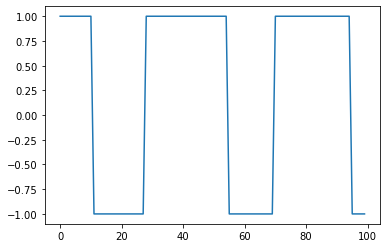

In [ ]:
fname = "./datasets/AFDpresidentutf8/corpus.tache1.learn.utf8"
alltxts,alllabs = load_pres(fname)

plt.figure()
plt.plot(list(range(len(alllabs[0:100]))),alllabs[0:100])

**Une méthode de post-traitement pour améliorer les résultats consistent à lisser les résultats de la prédictions d'une phrases par les prédictions voisines, en utilisant par exemple une convolution par une filtre Gaussien. Compléter la fonction ci-dessous et tester l'impact de ce lissage sur les performances.**

In [ ]:
def gaussian_smoothing(pred, size):
     # LISSAGE par un filtre Gaussien de taille size - vous pouvez utiliser np.convolve 
    return 0


## 4) Estimer les performances de généralisation d'une méthodes
**Ce sera l'enjeu principal du projet : vous disposez d'un ensemble de données, et vous évaluerez les performances sur un ensemble de test auquel vous n'avez pas accès. Il faut donc être capable d'estimer les performances de généralisation du modèles à partir des données d'entraînement.**


Avant de lancer de grandes expériences, il faut se construire une base de travail solide en étudiant les questions suivantes:

- Combien de temps ça prend d'apprendre un classifieur NB/SVM/RegLog sur ces données en fonction de la taille du vocabulaire?
- La validation croisée est-elle nécessaire? Est ce qu'on obtient les mêmes résultats avec un simple *split*?
- La validation croisée est-elle stable? A partir de combien de fold (travailler avec différentes graines aléatoires et faire des statistiques basiques)?